In [74]:
import os
import glob
import math
import time
import string
import random
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
def find_files(path):
    return glob.glob(path)

In [3]:
find_files("datasets/names_data/names/*.txt")

['datasets/names_data/names/Czech.txt',
 'datasets/names_data/names/German.txt',
 'datasets/names_data/names/Arabic.txt',
 'datasets/names_data/names/Japanese.txt',
 'datasets/names_data/names/Chinese.txt',
 'datasets/names_data/names/Vietnamese.txt',
 'datasets/names_data/names/Russian.txt',
 'datasets/names_data/names/French.txt',
 'datasets/names_data/names/Irish.txt',
 'datasets/names_data/names/English.txt',
 'datasets/names_data/names/Spanish.txt',
 'datasets/names_data/names/Greek.txt',
 'datasets/names_data/names/Italian.txt',
 'datasets/names_data/names/Portuguese.txt',
 'datasets/names_data/names/Scottish.txt',
 'datasets/names_data/names/Dutch.txt',
 'datasets/names_data/names/Korean.txt',
 'datasets/names_data/names/Polish.txt']

In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
def unicode_to_ascii(word):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", word)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )

In [6]:
unicode_to_ascii("Ślusàrski"), unicode_to_ascii("Jalapeño")

('Slusarski', 'Jalapeno')

In [7]:
def read_lines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicode_to_ascii(line) for line in lines]

In [8]:
category_lines = {}
all_categories = []


for filename in find_files("datasets/names_data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [9]:
category_lines["Italian"][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [32]:
def letter_to_index(letter):
    return all_letters.find(letter)


def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor


def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx] = letter_to_tensor(letter)
    return tensor


def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [22]:
print(letter_to_tensor("J"))
print(line_to_tensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [26]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
    ):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_2_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_2_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_2_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        input,
        hidden,
    ):
        hidden = F.tanh(self.input_2_hidden(input) + self.hidden_2_hidden(hidden))
        output = self.hidden_2_output(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(
        self,
    ):
        return torch.zeros(1, self.hidden_size)

In [37]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
input = line_to_tensor("Albert")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output.shape, next_hidden.shape, category_from_output(output))

torch.Size([1, 18]) torch.Size([1, 128]) ('German', 1)


In [50]:
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [53]:
for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print("category =", category, " line =", line)

category = Greek  line = Milionis
category = Dutch  line = Klerkx
category = Czech  line = Stramba
category = Russian  line = Abarinov
category = Scottish  line = Millar
category = French  line = Tailler
category = Arabic  line = Sayegh
category = French  line = Gagnon
category = Arabic  line = Maroun
category = Spanish  line = Felix


In [54]:
criterion = nn.NLLLoss()
learning_rate = 5e-3

In [55]:
def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [64]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

In [60]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

In [61]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = "✓" if guess == category else f"✗ ({category})"
        print(f"{time_since(start)}:{iter} {loss:.4f} {correct}")
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

0m 2s:5000 2.1579 ✗ (Scottish)
0m 5s:10000 0.8323 ✓
0m 7s:15000 2.0355 ✗ (English)
0m 10s:20000 2.6658 ✗ (Scottish)
0m 12s:25000 2.3586 ✗ (English)
0m 15s:30000 3.5945 ✗ (Czech)
0m 17s:35000 1.9107 ✗ (French)
0m 20s:40000 0.4087 ✓
0m 22s:45000 0.4424 ✓
0m 25s:50000 1.8229 ✗ (Scottish)
0m 27s:55000 0.4918 ✓
0m 30s:60000 0.7215 ✓
0m 32s:65000 0.3911 ✓
0m 35s:70000 1.5332 ✗ (Italian)
0m 37s:75000 1.2412 ✗ (Spanish)
0m 40s:80000 1.5878 ✗ (Chinese)
0m 43s:85000 0.2202 ✓
0m 45s:90000 0.0634 ✓
0m 48s:95000 1.5015 ✗ (Dutch)
0m 50s:100000 0.0138 ✓


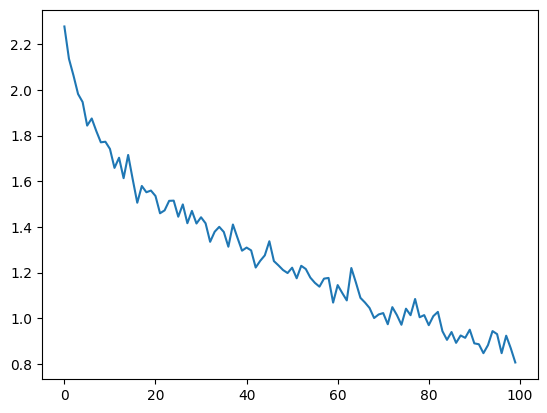

In [63]:
plt.plot(all_losses)

In [65]:
n_confusion = 10000
confusion = torch.zeros(n_categories, n_categories)

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [67]:
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

/var/folders/zv/qv06y_fn12dcgpls9z54mk7h0000gn/T/ipykernel_5083/1641162545.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/zv/qv06y_fn12dcgpls9z54mk7h0000gn/T/ipykernel_5083/1641162545.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


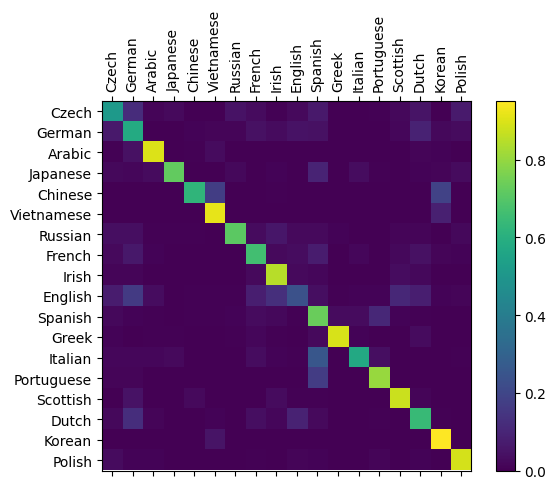

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [80]:
def predict(input_line, n_predictions=3):
    print(f'\nuser input: {input_line}')
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'{i+1}. {all_categories[category_index]}: {value}')
            predictions.append([value, all_categories[category_index]])

predict('Elon')
predict('Jackson')
predict('Satoshi')


user input: Elon
1. English: -0.882845401763916
2. Irish: -1.247511386871338
3. Scottish: -1.5735678672790527

user input: Jackson
1. Scottish: -0.025896284729242325
2. English: -4.0196051597595215
3. Czech: -5.806127548217773

user input: Satoshi
1. Japanese: -0.3907485008239746
2. Italian: -2.2329301834106445
3. Portuguese: -2.6126673221588135
